# Basic Text Classification with Naive Bayes
***
In the mini-project, you'll learn the basics of text analysis using a subset of movie reviews from the rotten tomatoes database. You'll also use a fundamental technique in Bayesian inference, called Naive Bayes. This mini-project is based on [Lab 10 of Harvard's CS109](https://github.com/cs109/2015lab10) class.  Please free to go to the original lab for additional exercises and solutions.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

# Table of Contents

* [Rotten Tomatoes Dataset](#Rotten-Tomatoes-Dataset)
    * [Explore](#Explore)
* [The Vector Space Model and a Search Engine](#The-Vector-Space-Model-and-a-Search-Engine)
    * [In Code](#In-Code)
* [Naive Bayes](#Naive-Bayes)
    * [Multinomial Naive Bayes and Other Likelihood Functions](#Multinomial-Naive-Bayes-and-Other-Likelihood-Functions)
    * [Picking Hyperparameters for Naive Bayes and Text Maintenance](#Picking-Hyperparameters-for-Naive-Bayes-and-Text-Maintenance)
* [Interpretation](#Interpretation)


## Rotten Tomatoes Dataset

In [2]:
critics = pd.read_csv('./critics.csv')
#let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


### Explore

In [3]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size


print("Number of reviews: {:d}".format(n_reviews))
print("Number of critics: {:d}".format(n_critics))
print("Number of movies:  {:d}".format(n_movies))

Number of reviews: 15561
Number of critics: 623
Number of movies:  1921


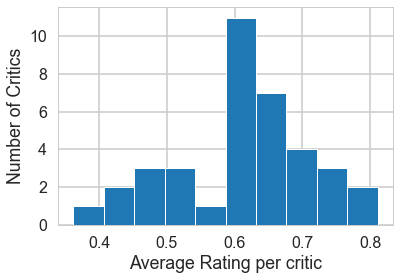

In [4]:
df = critics.copy()
df['fresh'] = df.fresh == 'fresh'
grp = df.groupby('critic')
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic

means[counts > 100].hist(bins=10, edgecolor='w', lw=1)
plt.xlabel("Average Rating per critic")
plt.ylabel("Number of Critics")
plt.yticks([0, 2, 4, 6, 8, 10]);

<div class="span5 alert alert-info">
<h3>Exercise Set I</h3>
<br/>
<b>Exercise:</b> Look at the histogram above. Tell a story about the average ratings per critic. What shape does the distribution look like? What is interesting about the distribution? What might explain these interesting things?
</div>

#### Exercise: 

The range of movie rating is from 0 to 1. It is natural to expect that the average movie rating of a critic would be around 0.5 since the rating is relative, not absolute, i.e. a movie being reviewed is compared against the previous movies. This means that it is expected that average movie ratings would be spread following a normal distribution and critics' average rating would follow the same with half the movies being rated as bad (rating < 0.5) and the other half being rated as good (rating > 0.5)

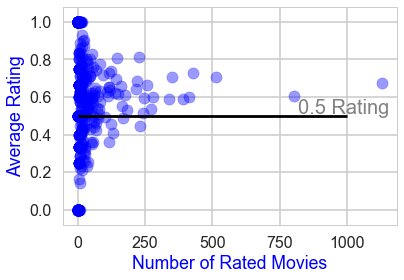

In [5]:
plt.scatter(counts.values, means.values, color='blue',alpha=.4)
plt.hlines(0.5,0,1000)
plt.text(820, 0.51, '0.5 Rating',fontsize=20, color='grey')
plt.ylabel('Average Rating',color='blue')
plt.xlabel('Number of Rated Movies',color='blue')

## The Vector Space Model and a Search Engine

All the diagrams here are snipped from [*Introduction to Information Retrieval* by Manning et. al.]( http://nlp.stanford.edu/IR-book/) which is a great resource on text processing. For additional information on text mining and natural language processing, see [*Foundations of Statistical Natural Language Processing* by Manning and Schutze](http://nlp.stanford.edu/fsnlp/).

Also check out Python packages [`nltk`](http://www.nltk.org/), [`spaCy`](https://spacy.io/), [`pattern`](http://www.clips.ua.ac.be/pattern), and their associated resources. Also see [`word2vec`](https://en.wikipedia.org/wiki/Word2vec).

Let us define the vector derived from document $d$ by $\bar V(d)$. What does this mean? Each document is treated as a vector containing information about the words contained in it. Each vector has the same length and each entry "slot" in the vector contains some kind of data about the words that appear in the document such as presence/absence (1/0), count (an integer) or some other statistic. Each vector has the same length because each document shared the same vocabulary across the full collection of documents -- this collection is called a *corpus*.

To define the vocabulary, we take a union of all words we have seen in all documents. We then just associate an array index with them. So "hello" may be at index 5 and "world" at index 99.

Suppose we have the following corpus:

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree. The grapes seemed ready to burst with juice, and the Fox's mouth watered as he gazed longingly at them.`

Suppose we treat each sentence as a document $d$. The vocabulary (often called the *lexicon*) is the following:

$V = \left\{\right.$ `a, along, and, as, at, beautiful, branches, bunch, burst, day, fox, fox's, from, gazed, grapes, hanging, he, juice, longingly, mouth, of, one, ready, ripe, seemed, spied, the, them, to, trained, tree, vine, watered, with`$\left.\right\}$

Then the document

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree`

may be represented as the following sparse vector of word counts:

$$\bar V(d) = \left( 4,1,0,0,0,1,1,1,0,1,1,0,1,0,1,1,0,0,0,0,2,1,0,1,0,0,1,0,0,0,1,1,0,0 \right)$$

or more succinctly as

`[(0, 4), (1, 1), (5, 1), (6, 1), (7, 1), (9, 1), (10, 1), (12, 1), (14, 1), (15, 1), (20, 2), (21, 1), (23, 1),`
`(26, 1), (30, 1), (31, 1)]`

along with a dictionary

``
{
    0: a, 1: along, 5: beautiful, 6: branches, 7: bunch, 9: day, 10: fox, 12: from, 14: grapes, 
    15: hanging, 19: mouth, 20: of, 21: one, 23: ripe, 24: seemed, 25: spied, 26: the, 
    30: tree, 31: vine, 
}
``

Then, a set of documents becomes, in the usual `sklearn` style, a sparse matrix with rows being sparse arrays representing documents and columns representing the features/words in the vocabulary.

Notice that this representation loses the relative ordering of the terms in the document. That is "cat ate rat" and "rat ate cat" are the same. Thus, this representation is also known as the Bag-Of-Words representation.

Here is another example, from the book quoted above, although the matrix is transposed here so that documents are columns:

![novel terms](terms.png)

Such a matrix is also catted a Term-Document Matrix. Here, the terms being indexed could be stemmed before indexing; for instance, `jealous` and `jealousy` after stemming are the same feature. One could also make use of other "Natural Language Processing" transformations in constructing the vocabulary. We could use Lemmatization, which reduces words to lemmas: work, working, worked would all reduce to work. We could remove "stopwords" from our vocabulary, such as common words like "the". We could look for particular parts of speech, such as adjectives. This is often done in Sentiment Analysis. And so on. It all depends on our application.

From the book:
>The standard way of quantifying the similarity between two documents $d_1$ and $d_2$  is to compute the cosine similarity of their vector representations $\bar V(d_1)$ and $\bar V(d_2)$:

$$S_{12} = \frac{\bar V(d_1) \cdot \bar V(d_2)}{|\bar V(d_1)| \times |\bar V(d_2)|}$$

![Vector Space Model](vsm.png)


>There is a far more compelling reason to represent documents as vectors: we can also view a query as a vector. Consider the query q = jealous gossip. This query turns into the unit vector $\bar V(q)$ = (0, 0.707, 0.707) on the three coordinates below. 

![novel terms](terms2.png)

>The key idea now: to assign to each document d a score equal to the dot product:

$$\bar V(q) \cdot \bar V(d)$$

Then we can use this simple Vector Model as a Search engine.

### In Code

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(text)))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print("")
print("Transformed text vector is \n{}".format(x))

# `get_feature_names` tracks which word is associated with each column of the transformed x
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
['hop', 'off', 'on', 'pop']


In [7]:
def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y
X, y = make_xy(critics)

## Naive Bayes

From Bayes' Theorem, we have that

$$P(c \vert f) = \frac{P(c \cap f)}{P(f)}$$

where $c$ represents a *class* or category, and $f$ represents a feature vector, such as $\bar V(d)$ as above. **We are computing the probability that a document (or whatever we are classifying) belongs to category *c* given the features in the document.** $P(f)$ is really just a normalization constant, so the literature usually writes Bayes' Theorem in context of Naive Bayes as

$$P(c \vert f) \propto P(f \vert c) P(c) $$

$P(c)$ is called the *prior* and is simply the probability of seeing class $c$. But what is $P(f \vert c)$? This is the probability that we see feature set $f$ given that this document is actually in class $c$. This is called the *likelihood* and comes from the data. One of the major assumptions of the Naive Bayes model is that the features are *conditionally independent* given the class. While the presence of a particular discriminative word may uniquely identify the document as being part of class $c$ and thus violate general feature independence, conditional independence means that the presence of that term is independent of all the other words that appear *within that class*. This is a very important distinction. Recall that if two events are independent, then:

$$P(A \cap B) = P(A) \cdot P(B)$$

Thus, conditional independence implies

$$P(f \vert c)  = \prod_i P(f_i | c) $$

where $f_i$ is an individual feature (a word in this example).

To make a classification, we then choose the class $c$ such that $P(c \vert f)$ is maximal.

There is a small caveat when computing these probabilities. For [floating point underflow](http://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html) we change the product into a sum by going into log space. This is called the LogSumExp trick. So:

$$\log P(f \vert c)  = \sum_i \log P(f_i \vert c) $$

There is another caveat. What if we see a term that didn't exist in the training data? This means that $P(f_i \vert c) = 0$ for that term, and thus $P(f \vert c)  = \prod_i P(f_i | c) = 0$, which doesn't help us at all. Instead of using zeros, we add a small negligible value called $\alpha$ to each count. This is called Laplace Smoothing.

$$P(f_i \vert c) = \frac{N_{ic}+\alpha}{N_c + \alpha N_i}$$

where $N_{ic}$ is the number of times feature $i$ was seen in class $c$, $N_c$ is the number of times class $c$ was seen and $N_i$ is the number of times feature $i$ was seen globally. $\alpha$ is sometimes called a regularization parameter.

### Multinomial Naive Bayes and Other Likelihood Functions

Since we are modeling word counts, we are using variation of Naive Bayes called Multinomial Naive Bayes. This is because the likelihood function actually takes the form of the multinomial distribution.

$$P(f \vert c) = \frac{\left( \sum_i f_i \right)!}{\prod_i f_i!} \prod_{f_i} P(f_i \vert c)^{f_i} \propto \prod_{i} P(f_i \vert c)$$

where the nasty term out front is absorbed as a normalization constant such that probabilities sum to 1.

There are many other variations of Naive Bayes, all which depend on what type of value $f_i$ takes. If $f_i$ is continuous, we may be able to use *Gaussian Naive Bayes*. First compute the mean and variance for each class $c$. Then the likelihood, $P(f \vert c)$ is given as follows

$$P(f_i = v \vert c) = \frac{1}{\sqrt{2\pi \sigma^2_c}} e^{- \frac{\left( v - \mu_c \right)^2}{2 \sigma^2_c}}$$

<div class="span5 alert alert-info">
<h3>Exercise Set II</h3>

<p><b>Exercise:</b> Implement a simple Naive Bayes classifier:</p>

<ol>
<li> split the data set into a training and test set
<li> Use `scikit-learn`'s `MultinomialNB()` classifier with default parameters.
<li> train the classifier over the training set and test on the test set
<li> print the accuracy scores for both the training and the test sets
</ol>

What do you notice? Is this a good classifier? If not, why not?
</div>

In [8]:
#your turn
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB


X_train, X_test, y_train, y_test = train_test_split(X,y)

model = MultinomialNB()

model.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [9]:
print('Accuracy on training data (%): {:2f}'.format(100 * model.score(X_train,y_train)))
print('Accuracy on test data (%):     {:2f}'.format(100 * model.score(X_test,y_test)))

Accuracy on training data (%): 91.996572
Accuracy on test data (%):     77.332305


The accuracy scores on test and train data there is overfitting. This classifer should be tweaked to improve accuracy.


### Picking Hyperparameters for Naive Bayes and Text Maintenance

We need to know what value to use for $\alpha$, and we also need to know which words to include in the vocabulary. As mentioned earlier, some words are obvious stopwords. Other words appear so infrequently that they serve as noise, and other words in addition to stopwords appear so frequently that they may also serve as noise.

First, let's find an appropriate value for `min_df` for the `CountVectorizer`. `min_df` can be either an integer or a float/decimal. If it is an integer, `min_df` represents the minimum number of documents a word must appear in for it to be included in the vocabulary. If it is a float, it represents the minimum *percentage* of documents a word must appear in to be included in the vocabulary. From the documentation:

>min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

<div class="span5 alert alert-info">
<h3>Exercise Set III</h3>

<p><b>Exercise:</b> Construct the cumulative distribution of document frequencies (df). The $x$-axis is a document count $x_i$ and the $y$-axis is the percentage of words that appear less than $x_i$ times. For example, at $x=5$, plot a point representing the percentage or number of words that appear in 5 or fewer documents.</p>

<p><b>Exercise:</b> Look for the point at which the curve begins climbing steeply. This may be a good value for `min_df`. If we were interested in also picking `max_df`, we would likely pick the value where the curve starts to plateau. What value did you choose?</p>
</div>

In [10]:
# Your turn.
df = critics.copy()
df.quote = df.quote.str.lower()
df.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"so ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,the year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,a winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,the film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"an entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


In [11]:
X_hyperparameter,y = make_xy(df)

In [12]:
df_word_f = pd.DataFrame(((X_hyperparameter>0).sum(axis=0).transpose()).A[:,0])
df_word_f= df_word_f.reset_index()
df_word_f.columns=['word','freq']
df_word_f.word=df_word_f.word+1
df_word_f.head()


,word,freq
0,1,7
1,2,1
2,3,10
3,4,1
4,5,1


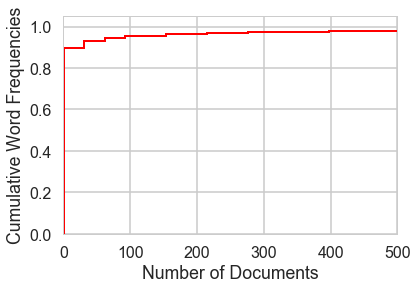

In [13]:
plt.hist(df_word_f.groupby(['freq']).size(),len(df_word_f['freq'].unique()),histtype='step',
         cumulative=1,normed=1,color='red',linewidth=2)
plt.xlim(-1, 500)
plt.xlabel('Number of Documents')
plt.ylabel('Cumulative Word Frequencies')
plt.show()

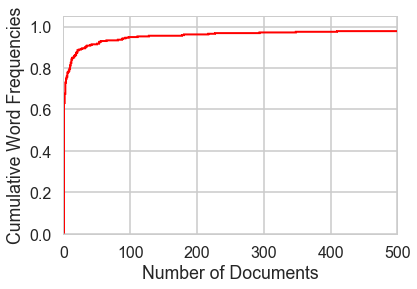

In [14]:
plt.hist(df_word_f.groupby(['freq']).size(),(df_word_f.groupby(['freq']).size()).index[-1],histtype='step',
         cumulative=1,normed=1,color='red',linewidth=2)
plt.xlim(-1, 500)
plt.xlabel('Number of Documents')
plt.ylabel('Cumulative Word Frequencies')
plt.show()

#### Exercise III:

The curve that plots the cummulative number of words against the total number of documents in which a word apprears we can see that the curve rises steeply just after 0, so the `min_df` will be something very close to 0. The curve starts to reach its peak around 0.2, this might be a good value for `max_df`. As we observed from the accuracy scores on testing and training data, there is a lot of overfit, so the classifier needs to be tweaked to improve accuracy.

The parameter $\alpha$ is chosen to be a small value that simply avoids having zeros in the probability computations. This value can sometimes be chosen arbitrarily with domain expertise, but we will use K-fold cross validation. In K-fold cross-validation, we divide the data into $K$ non-overlapping parts. We train on $K-1$ of the folds and test on the remaining fold. We then iterate, so that each fold serves as the test fold exactly once. The function `cv_score` performs the K-fold cross-validation algorithm for us, but we need to pass a function that measures the performance of the algorithm on each fold. 

In [15]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

We use the log-likelihood as the score here in `scorefunc`. The higher the log-likelihood, the better. Indeed, what we do in `cv_score` above is to implement the cross-validation part of `GridSearchCV`.

The custom scoring function `scorefunc` allows us to use different metrics depending on the decision risk we care about (precision, accuracy, profit etc.) directly on the validation set. You will often find people using `roc_auc`, precision, recall, or `F1-score` as the scoring function.

In [16]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

We'll cross-validate over the regularization parameter $\alpha$.

Let's set up the train and test masks first, and then we can run the cross-validation procedure.

In [17]:
from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(critics.shape[0]), train_size=0.7)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True

c:\users\kj.park\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


<div class="span5 alert alert-info">
<h3>Exercise Set IV</h3>

<p><b>Exercise:</b> What does using the function `log_likelihood` as the score mean? What are we trying to optimize for?</p>

<p><b>Exercise:</b> Without writing any code, what do you think would happen if you choose a value of $\alpha$ that is too high?</p>

<p><b>Exercise:</b> Using the skeleton code below, find the best values of the parameter `alpha`, and use the value of `min_df` you chose in the previous exercise set. Use the `cv_score` function above with the `log_likelihood` function for scoring.</p>
</div>

#### Exercise Set IV:

#### Exercise 1: 
We are trying to maximize the probability. For example, two separate models may that predict a particular class for a given response, but, we would like to chose the model that gives the higher probability for that class for optimal predictions.
 
#### Exercise 2:
the alpha is a smoothing parameter. The lower the value, the less smooth it will be; the higher the value, the lower the accuracy. High alpha reduces overfitting while low alpha may allow for overfitting, which is undesirable.


Using the skeleton code below, find the best values of the parameter `alpha`, and use the value of `min_df` you chose in the previous exercise set. Use the `cv_score` function above with the `log_likelihood` function for scoring.

Completed 

In [18]:
from sklearn.naive_bayes import MultinomialNB

#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50]
#min_dfs= [1,5,10,50,60,70,100] ## best 50
min_dfs=[0.00001,0.0001,0.0005,0.0008,0.001,0.003,0.005]#best 0.001
best_min_df = 0.001 # YOUR TURN: put your value of min_df here.

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
for mindf in min_dfs:
    for alpha in alphas:        
        vectorizer = CountVectorizer(min_df=mindf)       
        Xthis, ythis = make_xy(critics, vectorizer)
        Xtrainthis = Xthis[mask]
        ytrainthis = ythis[mask]
        clf = MultinomialNB(alpha=alpha)
        score = cv_score(clf,Xtrainthis,ytrainthis,log_likelihood)
        print('alpha:',alpha,' min df:',mindf,' score:',score)
        if score>maxscore:
            maxscore=score
            best_alpha=alpha
            best_min_df=mindf
print('\n','Best model alpha: ',best_alpha,'Best min_df: ',best_min_df,' Max score: ',maxscore)

alpha: 0.1  min df: 1e-05  score: -940.243144737
alpha: 1  min df: 1e-05  score: -722.317450816
alpha: 5  min df: 1e-05  score: -1278.40822933
alpha: 10  min df: 1e-05  score: -1440.68668617
alpha: 50  min df: 1e-05  score: -1399.26213506
alpha: 0.1  min df: 0.0001  score: -943.791427315
alpha: 1  min df: 0.0001  score: -616.495263529
alpha: 5  min df: 0.0001  score: -1011.39512769
alpha: 10  min df: 0.0001  score: -1242.15443477
alpha: 50  min df: 0.0001  score: -1344.69676641
alpha: 0.1  min df: 0.0005  score: -831.26756384
alpha: 1  min df: 0.0005  score: -574.809874104
alpha: 5  min df: 0.0005  score: -615.641024993
alpha: 10  min df: 0.0005  score: -800.048796905
alpha: 50  min df: 0.0005  score: -1160.40040176
alpha: 0.1  min df: 0.0008  score: -745.739818018
alpha: 1  min df: 0.0008  score: -572.527663267
alpha: 5  min df: 0.0008  score: -560.62104847
alpha: 10  min df: 0.0008  score: -674.601906268
alpha: 50  min df: 0.0008  score: -1059.85786869
alpha: 0.1  min df: 0.001  scor

In [19]:
log_probability = clf.predict_log_proba(Xtrainthis)
probility = clf.predict_proba(Xtrainthis)
temp_pred_df=pd.DataFrame(clf.predict(Xtrainthis))
temp_pred_df.columns=['Prediction']
temp_pred_df['class0LogProb']=log_probability[:,0]
temp_pred_df['class1LogProb']=log_probability[:,1]
temp_pred_df['class0Prob']=probility[:,0]
temp_pred_df['class1Prob']=probility[:,1]

In [20]:
temp_pred_df[(temp_pred_df.Prediction==0)].head(10)

,Prediction,class0LogProb,class1LogProb,class0Prob,class1Prob
33,0,-0.572384,-0.830523,0.564179,0.435821
53,0,-0.424737,-1.061148,0.653942,0.346058
54,0,-0.689737,-0.696569,0.501708,0.498292
93,0,-0.631568,-0.758768,0.531757,0.468243
100,0,-0.639689,-0.749626,0.527457,0.472543
117,0,-0.682249,-0.704165,0.505479,0.494521
122,0,-0.239494,-1.546584,0.787026,0.212974
132,0,-0.410336,-1.088941,0.663427,0.336573
135,0,-0.587404,-0.811409,0.555768,0.444232
164,0,-0.365780,-1.183044,0.693655,0.306345


In [21]:
temp_pred_df[(temp_pred_df.Prediction==1)].head(10)

,Prediction,class0LogProb,class1LogProb,class0Prob,class1Prob
0,1,-2.915689,-0.055689,0.054167,0.945833
1,1,-1.303079,-0.317034,0.271694,0.728306
2,1,-1.603122,-0.224729,0.201267,0.798733
3,1,-1.623603,-0.219633,0.197187,0.802813
4,1,-1.460220,-0.264207,0.232185,0.767815
5,1,-2.269721,-0.109080,0.103341,0.896659
6,1,-0.980565,-0.470162,0.375099,0.624901
7,1,-1.706069,-0.200377,0.181578,0.818422
8,1,-1.664649,-0.209804,0.189257,0.810743
9,1,-1.536227,-0.242315,0.215191,0.784809


<div class="span5 alert alert-info">
<h3>Exercise Set V: Working with the Best Parameters</h3>

<p><b>Exercise:</b> Using the best value of  `alpha` you just found, calculate the accuracy on the training and test sets. Is this classifier better? Why (not)?</p>

</div>

In [22]:
vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)
print('min-df:',best_min_df)
print('alpha:',best_alpha)
print('Accuracy on training data (%): {:2f}'.format(training_accuracy * 100))
print('Accuracy on test data (%):     {:2f}'.format(test_accuracy * 100))

min-df: 0.001
alpha: 5
Accuracy on training data (%): 80.980938
Accuracy on test data (%):     71.685641


In [23]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, clf.predict(xtest)))

[[2080 2168]
 [ 916 5728]]


#### Exercise Set V:

##### The previous run with the model looked like this:

Accuracy on training data (%): 92.270780

Accuracy on test data (%):     76.895400


##### The most recent run:
Accuracy on training data (%): 80.402656

Accuracy on test data (%):     72.006978

However, the second run has much less overfitting on the data.

## Interpretation

### What are the strongly predictive features?

We use a neat trick to identify strongly predictive features (i.e. words). 

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.
* use the trained classifier to make predictions on this matrix
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

In [24]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
         masterpiece 0.87
            american 0.86
        entertaining 0.85
               gives 0.84
            touching 0.83
             delight 0.83
                ever 0.83
               years 0.83
           excellent 0.83
              cinema 0.83
Bad words	     P(fresh | word)
      disappointment 0.29
            tiresome 0.29
           pointless 0.29
          uninspired 0.28
       unfortunately 0.27
               feels 0.27
               fails 0.27
                dull 0.24
               bland 0.24
                lame 0.24


<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Why does this method work? What does the probability for each row in the identity matrix represent</p>

</div>

The above exercise is an example of *feature selection*. There are many other feature selection methods. A list of feature selection methods available in `sklearn` is [here](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection). The most common feature selection technique for text mining is the chi-squared $\left( \chi^2 \right)$ [method](http://nlp.stanford.edu/IR-book/html/htmledition/feature-selectionchi2-feature-selection-1.html).

#### Exercise Set VI:

This bayesian method works as the probability of each row in the identity matrix serves as the probability of each document in the corpus as a "Fresh" or (1) Rotten Tomatoes rating.

### Prediction Errors

We can see mis-predictions as well.

In [25]:
x, y = make_xy(critics, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print(critics[y == 0].quote.iloc[row])
    print("")

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print(critics[y == 1].quote.iloc[row])
    print("")

Mis-predicted Rotten quotes
---------------------------
Directed with composure, but no great fervour, the film's conspicuously uninterested in American football, and much concerned with testing the limits and the resilience of the American dream.

Everytime I see one of these antiseptic Disney films, I'm reminded of the thrills and genuine artistry that went into the studio's films during its golden age in the 1940s and 1950s.

Despite some likable performances (Epps is especially winning), the drama in Higher Learning is constricted, hemmed in by Singleton's compulsion to view his characters as walking paradigms of racial and sexual politics.

With its feints at horror and pathos, the third Star Wars film is the most Disney-esque in its emotional outline, yet that outline is buried beneath an obnoxiously hyped-up pace that reduces the emotions to rubble.

All of the special effects in the world, and all of the great makeup, and all of the great Muppet creatures can't save a movie tha

<div class="span5 alert alert-info">
<h3>Exercise Set VII: Predicting the Freshness for a New Review</h3>
<br/>
<div>
<b>Exercise:</b>
<ul>
<li> Using your best trained classifier, predict the freshness of the following sentence: *'This movie is not remarkable, touching, or superb in any way'*
<li> Is the result what you'd expect? Why (not)?
</ul>
</div>
</div>

In [26]:
#your turn
test_string = ['This movie is not remarkable, touching, or superb in any way']
test_string_vect = vectorizer.transform(test_string)
if clf.predict(test_string_vect)[0]==1:
    print('Model predicts as **Fresh** with a probability of  %2.2f' %(100*clf.predict_proba(test_string_vect)[0,1]))
else:
    print('Model predicts as **Rotten** with a probability of  %2.2f' %(100*clf.predict_proba(test_string_vect)[0,0]))


Model predicts as **Fresh** with a probability of  94.56


#### Exercise: 

The model predicted the review as Fresh, despite the negation word "not." The model saw the words such as "remarkable," "touching," and "superb" and attributed those within the document as positive overall score. With no weights on words, the model took the overall positive associative words to ranked the review as 'Fresh'

### Aside: TF-IDF Weighting for Term Importance

TF-IDF stands for 

`Term-Frequency X Inverse Document Frequency`.

In the standard `CountVectorizer` model above, we used just the term frequency in a document of words in our vocabulary. In TF-IDF, we weight this term frequency by the inverse of its popularity in all documents. For example, if the word "movie" showed up in all the documents, it would not have much predictive value. It could actually be considered a stopword. By weighing its counts by 1 divided by its overall frequency, we downweight it. We can then use this TF-IDF weighted features as inputs to any classifier. **TF-IDF is essentially a measure of term importance, and of how discriminative a word is in a corpus.** There are a variety of nuances involved in computing TF-IDF, mainly involving where to add the smoothing term to avoid division by 0, or log of 0 errors. The formula for TF-IDF in `scikit-learn` differs from that of most textbooks: 

$$\mbox{TF-IDF}(t, d) = \mbox{TF}(t, d)\times \mbox{IDF}(t) = n_{td} \log{\left( \frac{\vert D \vert}{\vert d : t \in d \vert} + 1 \right)}$$

where $n_{td}$ is the number of times term $t$ occurs in document $d$, $\vert D \vert$ is the number of documents, and $\vert d : t \in d \vert$ is the number of documents that contain $t$

In [27]:
# http://scikit-learn.org/dev/modules/feature_extraction.html#text-feature-extraction
# http://scikit-learn.org/dev/modules/classes.html#text-feature-extraction-ref
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
Xtfidf=tfidfvectorizer.fit_transform(critics.quote)

<div class="span5 alert alert-info">
<h3>Exercise Set VIII: Enrichment</h3>

<p>
There are several additional things we could try. Try some of these as exercises:
<ol>
<li> Build a Naive Bayes model where the features are n-grams instead of words. N-grams are phrases containing n words next to each other: a bigram contains 2 words, a trigram contains 3 words, and 6-gram contains 6 words. This is useful because "not good" and "so good" mean very different things. On the other hand, as n increases, the model does not scale well since the feature set becomes more sparse.
<li> Try a model besides Naive Bayes, one that would allow for interactions between words -- for example, a Random Forest classifier.
<li> Try adding supplemental features -- information about genre, director, cast, etc.
<li> Use word2vec or [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) to group words into topics and use those topics for prediction.
<li> Use TF-IDF weighting instead of word counts.
</ol>
</p>

<b>Exercise:</b> Try a few of these ideas to improve the model (or any other ideas of your own). Implement here and report on the result.
</div>

In [28]:
def find_good_bad_words(vectorizer,clf):
    words = np.array(vectorizer.get_feature_names())
    x = np.eye(len(words))
    probs = clf.predict_log_proba(x)[:, 0]
    ind = np.argsort(probs)

    good_words = words[ind[:10]]
    bad_words = words[ind[-10:]]

    good_prob = probs[ind[:10]]
    bad_prob = probs[ind[-10:]]
    print("Good words\t     P(fresh | word)")
    for w, p in zip(good_words, good_prob):
        print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

    print("Bad words\t     P(fresh | word)")
    for w, p in zip(bad_words, bad_prob):
        print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))



#### Exercise 1:

In [29]:
# Your turn

def clf_score(clf, x, y):
    score = clf.score(x,y)
    return score


alphas = [1,5,10,50]
ngrm_min_df = [0,0.00009,0.0001,0.001,0.005,0.01]
best_score=-np.inf
best_alpha, best_min_df = None, None
for alpha in alphas:
    for min_df in ngrm_min_df:
        vectorizer = CountVectorizer(min_df=min_df,ngram_range=(1, 3))            
        X, y = make_xy(critics, vectorizer)
        X_train = X[mask]
        y_train = y[mask]
        clf = MultinomialNB(alpha=alpha)
        score = cv_score(clf,X_train,y_train,clf_score)
        print('alpha :',alpha,' min_df :',min_df,' score :',score)
        if score > best_score:
            best_score=score
            best_alpha = alpha
            best_min_df = min_df

print('best alpha:',best_alpha,'best min-df:',best_min_df,'best score:',best_score)

alpha : 1  min_df : 0  score : 0.701221451834
alpha : 1  min_df : 9e-05  score : 0.7324887368
alpha : 1  min_df : 0.0001  score : 0.7324887368
alpha : 1  min_df : 0.001  score : 0.73720287071
alpha : 1  min_df : 0.005  score : 0.670592433976
alpha : 1  min_df : 0.01  score : 0.651960588555
alpha : 5  min_df : 0  score : 0.624543103112
alpha : 5  min_df : 9e-05  score : 0.641892676568
alpha : 5  min_df : 0.0001  score : 0.641892676568
alpha : 5  min_df : 0.001  score : 0.712784850509
alpha : 5  min_df : 0.005  score : 0.664594880552
alpha : 5  min_df : 0.01  score : 0.647033698943
alpha : 10  min_df : 0  score : 0.613832792837
alpha : 10  min_df : 9e-05  score : 0.618545090668
alpha : 10  min_df : 0.0001  score : 0.618545090668
alpha : 10  min_df : 0.001  score : 0.684509915976
alpha : 10  min_df : 0.005  score : 0.663093885626
alpha : 10  min_df : 0.01  score : 0.649602833071
alpha : 50  min_df : 0  score : 0.608264422978
alpha : 50  min_df : 9e-05  score : 0.608264422978
alpha : 50  m

In [30]:
vectorizer = CountVectorizer(min_df=best_min_df,ngram_range=(1, 3),token_pattern=r'\b\w+\b')  
X, y = make_xy(critics, vectorizer)
X_train=X[mask]
y_train=y[mask]
X_test=X[~mask]
y_test=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(X_train, y_train)

training_accuracy = clf.score(X_train, y_train)
test_accuracy = clf.score(X_test, y_test)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.850717
Accuracy on test data:     0.721080


#### From first glance, this model has a great score on accuracy and does not appear to be overfitting in any way. Overall this looks like a good model.

In [31]:
find_good_bad_words(vectorizer, clf)

Good words	     P(fresh | word)
         masterpiece 0.96
             delight 0.95
           the right 0.95
              finest 0.95
            makes it 0.94
           ever made 0.94
               known 0.94
          thoroughly 0.94
        the american 0.93
    entertaining and 0.92
Bad words	     P(fresh | word)
             s not a 0.11
       collection of 0.11
          collection 0.11
            tiresome 0.10
           pointless 0.10
      disappointment 0.10
             only to 0.09
          uninspired 0.09
               bland 0.07
                lame 0.07


#### Exercise 2:

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
mindfs=[0.00001,0.0005,0.0001,0.001]
for mindf in mindfs:
    vectorizer = CountVectorizer(min_df=mindf,ngram_range=(1, 2),token_pattern=r'\b\w+\b')
    X, y = make_xy(critics, vectorizer)
    X_train = X[mask]
    y_train = y[mask]
    X_test = X[~mask]
    y_test = y[~mask]
    features=np.sqrt(len(vectorizer.get_feature_names()))
    parameters = {"n_estimators": [10,20,40,50,60,70],"max_features":['auto','sqrt','log2']}
    clf = RandomForestClassifier()
    fitmodel = GridSearchCV(clf, param_grid=parameters, scoring="accuracy")
    fitmodel.fit(X_train, y_train)
    print('min_df:',mindf)
    print('\n')
    print('Best Estimator:',fitmodel.best_estimator_)
    print('\n')
    print('Best Parameters:',fitmodel.best_params_)
    print('\n')
    print('Best Score:',fitmodel.best_score_)
    print('\n')
    print('Grid Scores:', fitmodel.grid_scores_)

c:\users\kj.park\appdata\local\programs\python\python36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
c:\users\kj.park\appdata\local\programs\python\python36\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


min_df: 1e-05


Best Estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


Best Parameters: {'max_features': 'log2', 'n_estimators': 60}


Best Score: 0.6637395587920325


Grid Scores: [mean: 0.63975, std: 0.00841, params: {'max_features': 'auto', 'n_estimators': 10}, mean: 0.64296, std: 0.01223, params: {'max_features': 'auto', 'n_estimators': 20}, mean: 0.64639, std: 0.00292, params: {'max_features': 'auto', 'n_estimators': 40}, mean: 0.64125, std: 0.00204, params: {'max_features': 'auto', 'n_estimators': 50}, mean: 0.64146, std: 0.00496, params: {'max_features': 'auto', 'n_estimators': 60}, mean: 0.64575, std:

In [33]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [34]:
find_good_bad_words(vectorizer, clf)

Good words	     P(fresh | word)
               funny 0.99
           hilarious 0.98
        entertaining 0.97
             perfect 0.92
                work 0.91
         masterpiece 0.90
           inventive 0.90
                good 0.89
         fascinating 0.87
       entertainment 0.87
Bad words	     P(fresh | word)
             muddled 0.20
                camp 0.20
                 not 0.20
              sloppy 0.18
                   a 0.16
                dull 0.15
            emotions 0.14
         predictable 0.14
             tedious 0.13
       disappointing 0.10


In [36]:
training_accuracy = clf.score(X_train, y_train)
test_accuracy = clf.score(X_test, y_test)

print("Accuracy on training data (Random Forest): {:2f}".format(training_accuracy))
print("Accuracy on test data (Random Forest):     {:2f}".format(test_accuracy))

Accuracy on training data (Random Forest): 0.996787
Accuracy on test data (Random Forest):     0.692802


#### Looks like the model scored worse, and it really seems like there is overfitting going on for the traning data.

#### Exercise 3:

In [38]:
#create supplmental features by adding critic 	fresh 	imdb 	publication 	quote 	review_date 	rtid 	title

In [43]:
import scipy
def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = TfidfVectorizer()
    X_combined = (critics.quote + ' ' + critics.title + ' ' + critics.publication).values
    X = vectorizer.fit_transform(X_combined)
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y

X, y = make_xy(critics)

X_train = X[mask]
y_train = y[mask]
X_test = X[~mask]
y_test = y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(X_train, y_train)

training_accuracy = clf.score(X_train, y_train)
test_accuracy = clf.score(X_test, y_test)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.769972
Accuracy on test data:     0.653691


#### Worse score than before. The chosen extra features for text processing were title, and publication. Adding extra values decreased score accuracies

#### Exercise 4:

In [46]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
lda_vec = CountVectorizer(min_df=0.00009,ngram_range=(1, 2),token_pattern=r'\b\w+\b') 

def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y


X, y = make_xy(critics, lda_vec)

X_train = X[mask]
y_train = y[mask]
X_test = X[~mask]
y_test = y[~mask]


lda = LDA(n_topics=20)
lda.fit(X_train)
train_features = lda.transform(X_train)
test_features = lda.transform(X_test)
X_train_features = scipy.sparse.hstack((X_train, sp.sparse.csc_matrix(train_features)))
X_test_features = scipy.sparse.hstack((X_test, sp.sparse.csc_matrix(test_features)))


clf = MultinomialNB(alpha=1).fit(X_train_features, y_train)
#clf = MultinomialNB(alpha=5).fit(xtrain, ytrain)


training_accuracy = clf.score(X_train_features, y_train)
test_accuracy = clf.score(X_test_features, y_test)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))



c:\users\kj.park\appdata\local\programs\python\python36\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
c:\users\kj.park\appdata\local\programs\python\python36\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Accuracy on training data: 0.974299
Accuracy on test data:     0.745593


#### Not a near perfect score so this model is great. LDA got us closer to a greater test score at 74.56

#### Exercise 5:

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer

def clf_score(clf, x, y):
    score = clf.score(x,y)
    return score


alphas = [1,5,10,50]
ngrm_min_df = [0,0.00009,0.0001,0.001,0.005,0.01]
best_score=-np.inf
best_alpha, best_min_df = None, None
for alpha in alphas:
    for min_df in ngrm_min_df:
        vectorizer = TfidfVectorizer(min_df=min_df, stop_words='english', ngram_range=(1,3))          
        X, y = make_xy(critics, vectorizer)
        X_train = X[mask]
        y_train = y[mask]
        clf = MultinomialNB(alpha=alpha)
        score = cv_score(clf,X_train,y_train,clf_score)
        print('alpha :',alpha,' min_df :',min_df,' score :',score)
        if score > best_score:
            best_score=score
            best_alpha = alpha
            best_min_df = min_df

print('best alpha:',best_alpha,'best min-df:',best_min_df,'best score:',best_score)

alpha : 1  min_df : 0  score : 0.612120189759
alpha : 1  min_df : 9e-05  score : 0.668664550585
alpha : 1  min_df : 0.0001  score : 0.668664550585
alpha : 1  min_df : 0.001  score : 0.703576682709
alpha : 1  min_df : 0.005  score : 0.649601226501
alpha : 1  min_df : 0.01  score : 0.623688178632
alpha : 5  min_df : 0  score : 0.607835698433
alpha : 5  min_df : 9e-05  score : 0.609549449061
alpha : 5  min_df : 0.0001  score : 0.609549449061
alpha : 5  min_df : 0.001  score : 0.650027426436
alpha : 5  min_df : 0.005  score : 0.643602984547
alpha : 5  min_df : 0.01  score : 0.626470756993
alpha : 10  min_df : 0  score : 0.607835698433
alpha : 10  min_df : 9e-05  score : 0.608050060705
alpha : 10  min_df : 0.0001  score : 0.608050060705
alpha : 10  min_df : 0.001  score : 0.616616977767
alpha : 10  min_df : 0.005  score : 0.631822928501
alpha : 10  min_df : 0.01  score : 0.626898104478
alpha : 50  min_df : 0  score : 0.607835698433
alpha : 50  min_df : 9e-05  score : 0.607835698433
alpha : 

In [49]:
vectorizer = TfidfVectorizer(min_df=best_min_df,ngram_range=(1, 3),token_pattern=r'\b\w+\b')  
X, y = make_xy(critics, vectorizer)
X_train=X[mask]
y_train=y[mask]
X_test=X[~mask]
y_test=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(X_train, y_train)

training_accuracy = clf.score(X_train, y_train)
test_accuracy = clf.score(X_test, y_test)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.835082
Accuracy on test data:     0.718417


#### A good model, but not as great as the LDA